# Linear Discriminant Analysis: Group Review
# Quality: RECODED, Outliers: Original

## Set Working Directory

## Import Packages

In [1]:
library("tidyr")
library("corrplot")
library("MASS")
library("ggplot2")
library("tibble")
library("reshape2")

corrplot 0.92 loaded

Warning message:
“package ‘tibble’ was built under R version 4.1.2”

Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths




## Load in Data

In [2]:
wine <- read.csv("WineQT.csv")
head(wine)

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality,Id
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
1,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,0
2,7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5,1
3,7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5,2
4,11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6,3
5,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,4
6,7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5,5


### View Structure of the Dataset

In [3]:
str(wine)

'data.frame':	1143 obs. of  13 variables:
 $ fixed.acidity       : num  7.4 7.8 7.8 11.2 7.4 7.4 7.9 7.3 7.8 6.7 ...
 $ volatile.acidity    : num  0.7 0.88 0.76 0.28 0.7 0.66 0.6 0.65 0.58 0.58 ...
 $ citric.acid         : num  0 0 0.04 0.56 0 0 0.06 0 0.02 0.08 ...
 $ residual.sugar      : num  1.9 2.6 2.3 1.9 1.9 1.8 1.6 1.2 2 1.8 ...
 $ chlorides           : num  0.076 0.098 0.092 0.075 0.076 0.075 0.069 0.065 0.073 0.097 ...
 $ free.sulfur.dioxide : num  11 25 15 17 11 13 15 15 9 15 ...
 $ total.sulfur.dioxide: num  34 67 54 60 34 40 59 21 18 65 ...
 $ density             : num  0.998 0.997 0.997 0.998 0.998 ...
 $ pH                  : num  3.51 3.2 3.26 3.16 3.51 3.51 3.3 3.39 3.36 3.28 ...
 $ sulphates           : num  0.56 0.68 0.65 0.58 0.56 0.56 0.46 0.47 0.57 0.54 ...
 $ alcohol             : num  9.4 9.8 9.8 9.8 9.4 9.4 9.4 10 9.5 9.2 ...
 $ quality             : int  5 5 5 6 5 5 5 7 7 5 ...
 $ Id                  : int  0 1 2 3 4 5 6 7 8 10 ...


## Data Wrangling

### Recode Quality into Three Groups

In [4]:
wine$qualityR <- NA
wine$qualityR [wine$quality==3] <- 0
wine$qualityR [wine$quality==4] <- 0
wine$qualityR [wine$quality==5] <- 1
wine$qualityR [wine$quality==6] <- 1
wine$qualityR [wine$quality==7] <- 2
wine$qualityR [wine$quality==8] <- 2

### Remove Unnecessary Columns

In [5]:
wine_wrangled <- wine[, c(2,5,8,9,14)]
head(wine_wrangled)

,volatile.acidity,chlorides,density,pH,qualityR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.70,0.076,0.9978,3.51,1
2,0.88,0.098,0.9968,3.20,1
3,0.76,0.092,0.9970,3.26,1
4,0.28,0.075,0.9980,3.16,1
5,0.70,0.076,0.9978,3.51,1
6,0.66,0.075,0.9978,3.51,1


### Summarizing the Dataset

In [138]:
summary(wine_wrangled)

 volatile.acidity   chlorides          density             pH       
 Min.   :0.1200   Min.   :0.01200   Min.   :0.9901   Min.   :2.740  
 1st Qu.:0.3925   1st Qu.:0.07000   1st Qu.:0.9956   1st Qu.:3.205  
 Median :0.5200   Median :0.07900   Median :0.9967   Median :3.310  
 Mean   :0.5313   Mean   :0.08693   Mean   :0.9967   Mean   :3.311  
 3rd Qu.:0.6400   3rd Qu.:0.09000   3rd Qu.:0.9978   3rd Qu.:3.400  
 Max.   :1.5800   Max.   :0.61100   Max.   :1.0037   Max.   :4.010  
    quality     
 Min.   :3.000  
 1st Qu.:5.000  
 Median :6.000  
 Mean   :5.657  
 3rd Qu.:6.000  
 Max.   :8.000  

## Scale the Data: Scale Each Predictor Value

In [6]:
wine_wrangled[1:4] <- scale(wine_wrangled[1:4])

### Find the Mean of Each Predictor Value:  Mean Should == 0
### Find the Standard Deviation of Each Predictor Value:  Standard Deviation Should == 1

In [7]:
apply(wine_wrangled[1:4], 2, mean)
apply(wine_wrangled[1:4], 2, sd)

volatile.acidity        chlorides          density               pH 
   -1.652847e-16    -3.662422e-17     1.039748e-16    -8.347812e-16

volatile.acidity        chlorides          density               pH 
               1                1                1                1

## Create Training and Test Samples

### Making this Example Reproducible

In [8]:
set.seed(1)

### Using 70% of Dataset as Training Set, Remaining 30% as Testing Set

In [9]:
sample <- sample(c(TRUE, FALSE), nrow(wine_wrangled), replace=TRUE, prob=c(0.7,0.3))
train <- wine_wrangled[sample, ]
test <- wine_wrangled[!sample, ]

## Fit LDA Model

In [10]:
model <- lda(qualityR~., data=train)

### View Model Output

In [11]:
model

Call:
lda(qualityR ~ ., data = train)

Prior probabilities of groups:
      0       1       2 
0.03875 0.81375 0.14750 

Group means:
  volatile.acidity   chlorides      density          pH
0       1.00446698 -0.10367361  0.005651296  0.53093655
1       0.09140134  0.02043661  0.058451338  0.01519113
2      -0.72265686 -0.21999832 -0.273547676 -0.19634775

Coefficients of linear discriminants:
                       LD1        LD2
volatile.acidity 0.9106706  0.2070886
chlorides        0.1985976 -0.7306090
density          0.3157373 -0.5016395
pH               0.2912990  0.1980449

Proportion of trace:
   LD1    LD2 
0.9531 0.0469 

Prior probabilities of group: The proportions of each 'quality' rating in the training set.

Group means: The mean values for each predictor variable for each 'quality' rating.

Coefficients of linear discriminants: Linear combination of predictor variables used to form the decision rule of the LDA model.

### View Model Info

In [12]:
model$counts
model$prior
model$scaling
model$svd

0   1   2 
 31 651 118

0       1       2 
0.03875 0.81375 0.14750

,LD1,LD2
volatile.acidity,0.9106706,0.2070886
chlorides,0.1985976,-0.7306090
density,0.3157373,-0.5016395
pH,0.2912990,0.1980449


[1] 7.950447 1.764021

### Store Model Means

In [13]:
modelmeans <- model$means

### Convert Matrix to a Data Frame

In [14]:
modelmeans <- as.data.frame(modelmeans)
str(modelmeans)

'data.frame':	3 obs. of  4 variables:
 $ volatile.acidity: num  1.0045 0.0914 -0.7227
 $ chlorides       : num  -0.1037 0.0204 -0.22
 $ density         : num  0.00565 0.05845 -0.27355
 $ pH              : num  0.5309 0.0152 -0.1963


### Convert Row Labels to Columns

In [15]:
modelmeans <- tibble::rownames_to_column(modelmeans, "qualityR")

## Plot Means

### Melt Data Frame

In [16]:
mmodelmeans <- melt(modelmeans, id.vars="qualityR")

### All Variables on the Same Plot

ERROR while rich displaying an object: Error in FUN(X[[i]], ...): object 'quality' not found

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. repr_text.default(obj)
9. paste(

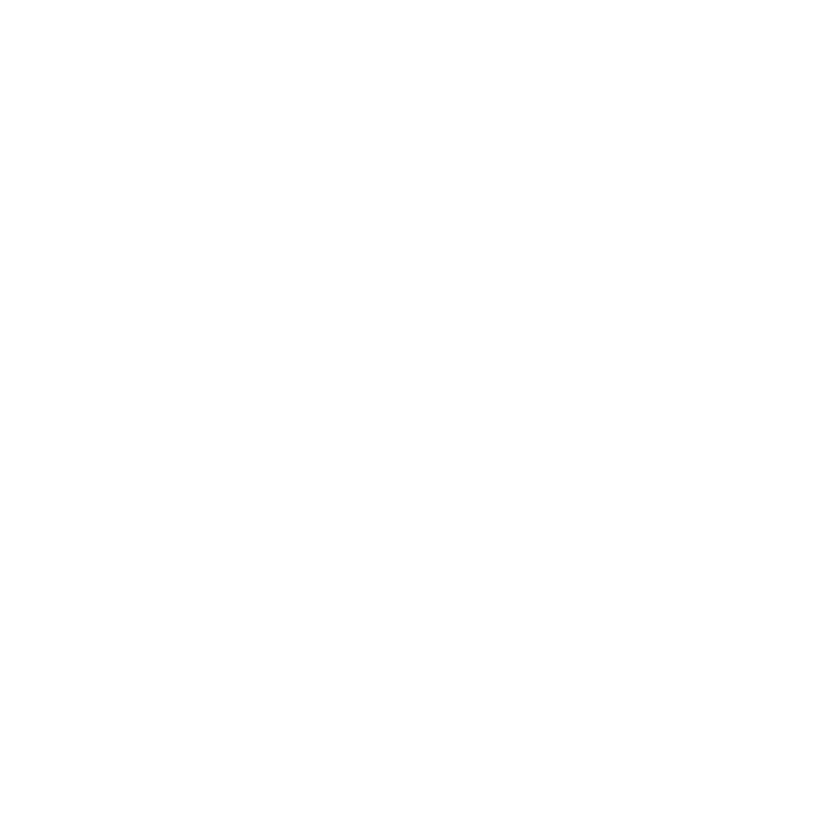

In [17]:
ggplot(mmodelmeans, aes(quality, value, group=variable, col=variable)) + ggtitle("All Variables vs. Quality")+ geom_line() + geom_point() + stat_smooth()

### Variables on Separate Plots

ERROR while rich displaying an object: Error in FUN(X[[i]], ...): object 'quality' not found

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. repr_text.default(obj)
9. paste(

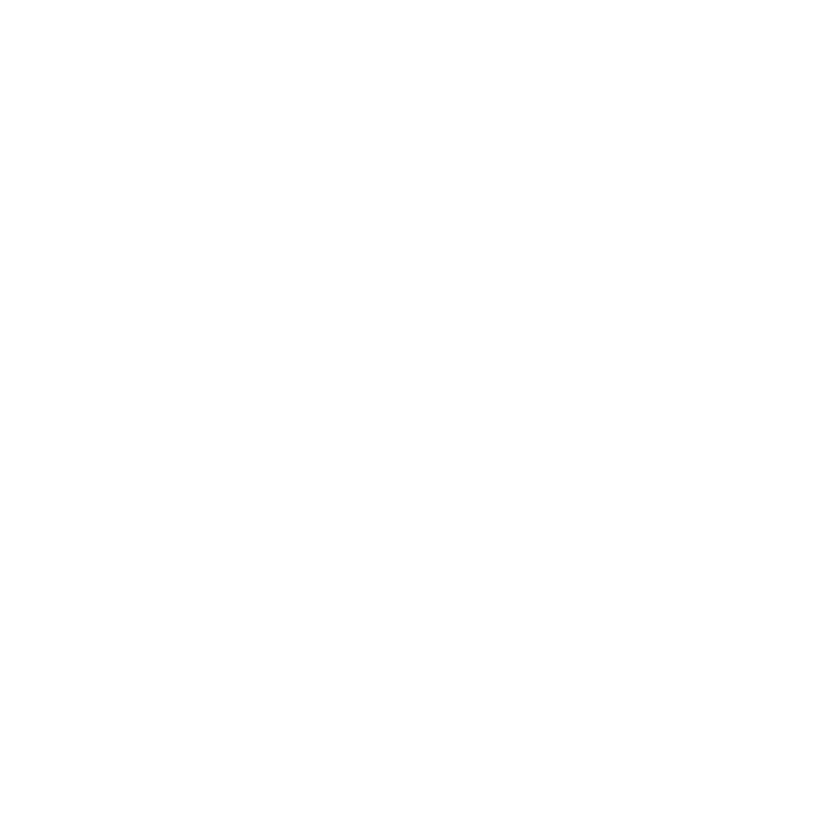

In [18]:
ggplot(mmodelmeans, aes(quality, value, group=variable, col=variable)) + ggtitle ("Separately Plotted Variables vs. Quality")+
  geom_point() + 
  stat_smooth() +
  facet_wrap(~variable)

## Assumptions Testing

### Misclassification Rate

In [19]:
lda.pred = (test$class)

In [20]:
lda.error = mean(default$default != lda.pred)

ERROR: Error in mean(default$default != lda.pred): object 'default' not found


In [21]:
lda.error

ERROR: Error in eval(expr, envir, enclos): object 'lda.error' not found


### Confusion Matrix

In [22]:
LDA_model = lda.cm

ERROR: Error in eval(expr, envir, enclos): object 'lda.cm' not found


In [23]:
LDA_model

ERROR: Error in eval(expr, envir, enclos): object 'LDA_model' not found


## LDA model: Make Predictions on Test Data

In [24]:
predicted <- predict(model, test)
names(predicted)

[1] "class"     "posterior" "x"

### View Predicted Class (First Six Observations)

In [25]:
head(predicted$class)

[1] 1 1 1 1 1 1
Levels: 0 1 2

### View Predicted Posterior Probability (First Six Observations)¶

In [26]:
head(predicted$posterior)

,0,1,2
4,0.003678563,0.6901224,0.30619903
6,0.075592617,0.8853544,0.03905293
7,0.032025977,0.8712111,0.09676291
15,0.018379246,0.8634723,0.11814842
17,0.012521832,0.8269567,0.16052150
18,0.014032561,0.8260119,0.15995554


### View Linear Discriminants (First Six Observations)¶

In [108]:
head(predicted$x)

,LD1,LD2,LD3,LD4
2,-1.9778909,0.8537230,-1.1994157,-0.6494332
6,-1.0784419,-0.9136991,0.6410399,0.9038224
8,-0.2825177,-0.6473146,-1.0742852,-0.5272994
10,-0.1433853,0.1363726,-0.4166806,-0.6304414
11,-0.2406689,-1.7901037,0.0799071,-0.6803499
12,-0.6399323,0.4674990,0.1952364,-0.3206199


## Accuracy of the Model

In [27]:
mean(predicted$class==test$quality)

[1] 0.8688047

## Visualize the Results

### Convert Quality to a Factor

In [39]:
wine_wrangled$quality = factor(wine_wrangled$qualityR, levels = c("0", "1", "2"), ordered = TRUE)
str(wine_wrangled)

'data.frame':	1143 obs. of  6 variables:
 $ volatile.acidity: num  0.939 1.941 1.273 -1.399 0.939 ...
 $ chlorides       : num  -0.231 0.234 0.107 -0.252 -0.231 ...
 $ density         : num  0.5556 0.0361 0.14 0.6595 0.5556 ...
 $ pH              : num  1.27 -0.709 -0.326 -0.964 1.27 ...
 $ qualityR        : num  1 1 1 1 1 1 1 2 2 1 ...
 $ quality         : Ord.factor w/ 3 levels "0"<"1"<"2": 2 2 2 2 2 2 2 3 3 2 ...


### Rebuild Model with 'Quality' as a Factor

In [40]:
set.seed(1)

In [41]:
sample <- sample(c(TRUE, FALSE), nrow(wine_wrangled), replace=TRUE, prob=c(0.7,0.3))
train <- wine_wrangled[sample, ]
test <- wine_wrangled[!sample, ]

In [42]:
LDAmodel <- lda(quality~., data=train)

ERROR: Error in lda.default(x, grouping, ...): variable 5 appears to be constant within groups


### Define Data to Plot

In [43]:
lda_plot <- cbind(train, predict(LDAmodel)$x)

ERROR: Error in model.matrix.default(Terms, newdata, contrasts = object$contrasts): model frame and formula mismatch in model.matrix()


### Create Plot

In [44]:
ggplot(lda_plot, aes(LD1, LD2)) +
  geom_point(aes(color = qualityR))

ERROR: Error in ggplot(lda_plot, aes(LD1, LD2)): object 'lda_plot' not found


## Identify Outliers

### Density

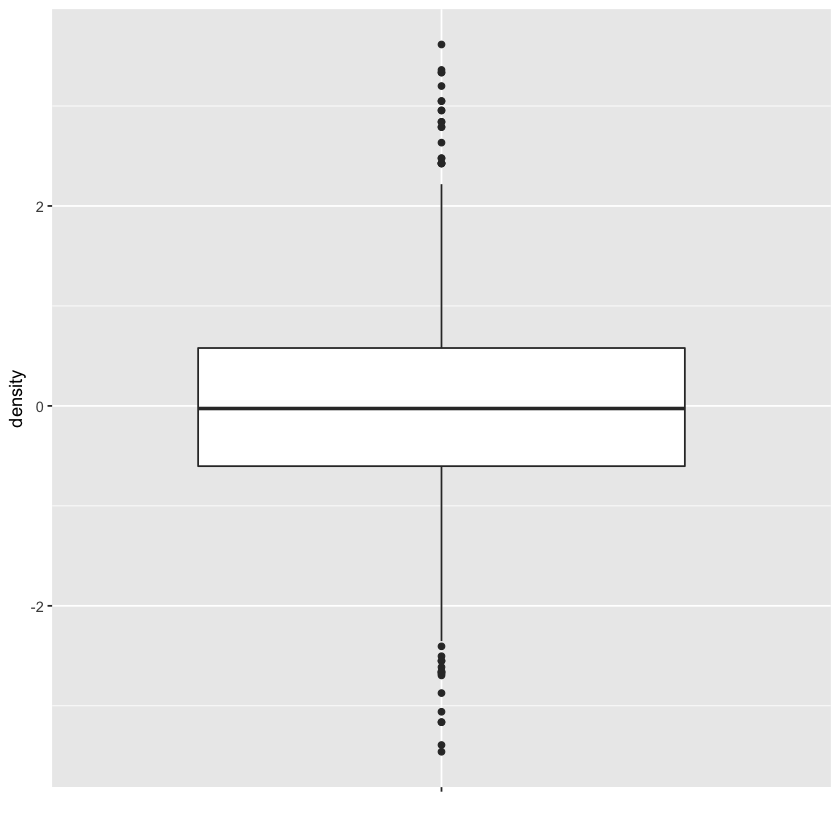

In [45]:
bp.density <- ggplot(wine_wrangled, aes(x = "", y = density)) + geom_boxplot() + xlab("")
bp.density

In [55]:
boxplot.stats(wine_wrangled$density)

$stats
[1] -2.35337829 -0.60278999 -0.02618672  0.57898698  2.21789086

$n
[1] 1143

$conf
[1] -0.08141602  0.02904257

$out
 [1] -2.665056 -2.665056  2.425676  2.477622  2.477622  2.633461 -2.872841
 [8]  2.841246  2.841246  2.425676  2.425676  3.360708  3.049031  2.425676
[15]  3.334735  3.334735  2.789300  2.789300 -2.613109  3.049031 -2.405325
[22] -2.696223 -3.163740 -3.163740  3.199675 -2.654666 -3.459833 -3.392303
[29] -2.680640 -3.059847 -2.504022  3.615245  2.955527 -2.550774  2.955527
[36] -2.550774

#### Density Outlier Count: 36

### Chlorides 

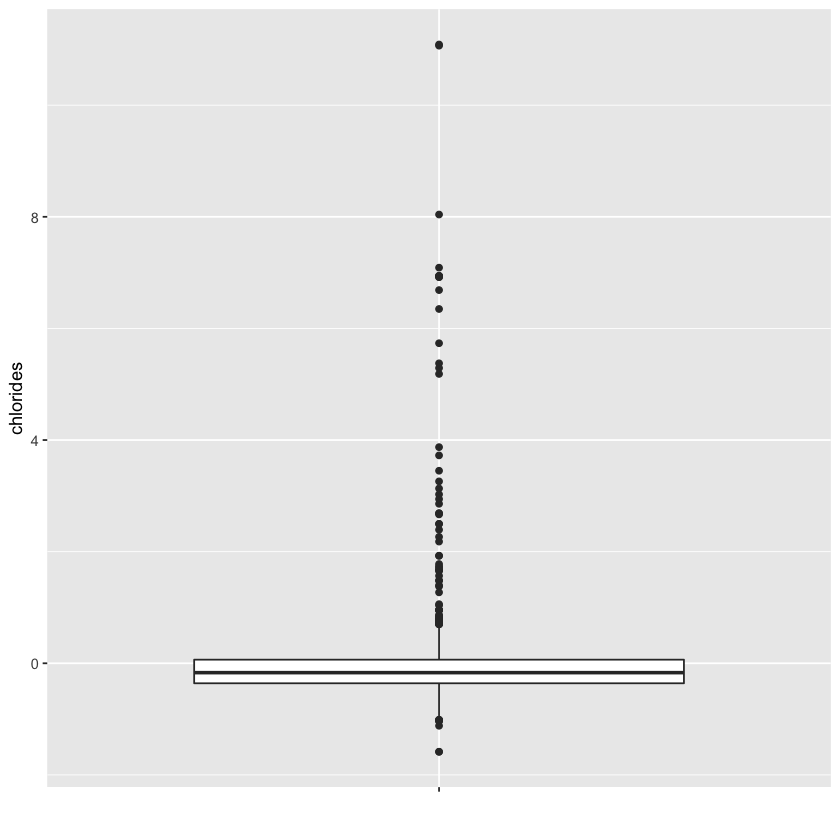

In [46]:
bp.chlorides <- ggplot(wine_wrangled, aes(x = "", y = chlorides)) + geom_boxplot() + xlab("")
bp.chlorides

In [47]:
boxplot.stats(wine_wrangled$chlorides)

$stats
[1] -0.9717626 -0.3582312 -0.1678248  0.0648940  0.6784255

$n
[1] 1143

$conf
[1] -0.1875992 -0.1480505

$out
 [1]  5.3751148  5.1847085  8.0408033  1.9266447 11.0661482  3.8730205
 [7] -1.0140752  5.2904897  3.7249266 11.0873045  5.7347712  2.6671137
[13]  2.6882700  0.7207380  0.8688318  0.6995817  0.7418943  0.7418943
[19]  0.7207380  0.8476755  1.3765820  0.8053630  0.7418943  2.3920824
[25]  2.9421451  3.4498953  0.7842068  2.8575201 -1.0140752  1.4823633
[31]  7.0887717 -1.1198565  6.3483026  6.9406779  1.4823633  3.2594890
[37]  2.1805198  0.9534568  0.8265193 -1.0352314  1.6516134  1.2708007
[43] -1.5852941 -1.5852941  2.2651448  0.9534568  1.5669883  0.6995817
[49]  0.6995817  0.7630505  0.7630505  6.9195216  1.7785509  1.9266447
[55]  1.6727696  1.0380819  0.9534568  0.9534568  0.7630505  0.7630505
[61]  6.6868028  1.0592381  6.9195216  1.6727696  1.7150821  6.9406779
[67]  1.3977383  6.9406779  0.7630505  2.6882700  1.7362384  2.4978637
[73]  2.4978637 -1.0140752  3.1325514  3.0267701 -1.0352314

#### Chlorides Outlier Count: 77

### Volatile Acidity

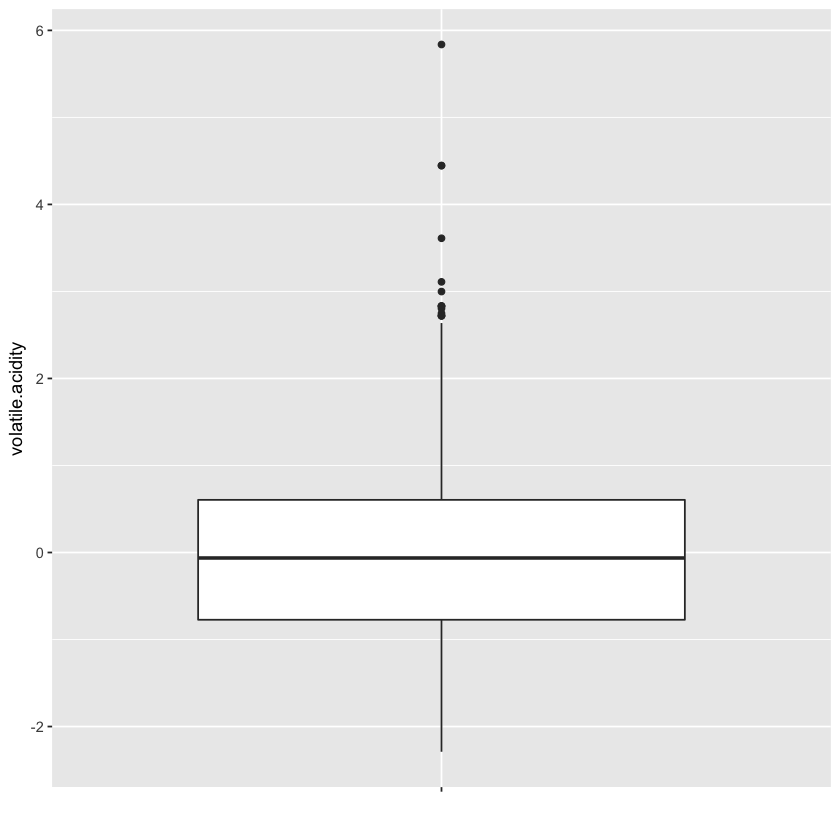

In [48]:
bp.volatile.acidity <- ggplot(wine_wrangled, aes(x = "", y = volatile.acidity)) + geom_boxplot() + xlab("")
bp.volatile.acidity

In [49]:
boxplot.stats(wine_wrangled$volatile.acidity)

$stats
[1] -2.28988070 -0.77290049 -0.06312075  0.60490723  2.63682569

$n
[1] 1143

$conf
[1] -0.127511371  0.001269862

$out
 [1] 2.720329 2.998674 4.446068 4.446068 2.831667 3.110012 2.831667 2.720329
 [9] 2.803833 2.748164 2.720329 5.837793 3.611033 2.831667

#### Volatile Acidity Outliers Count: 14

### pH

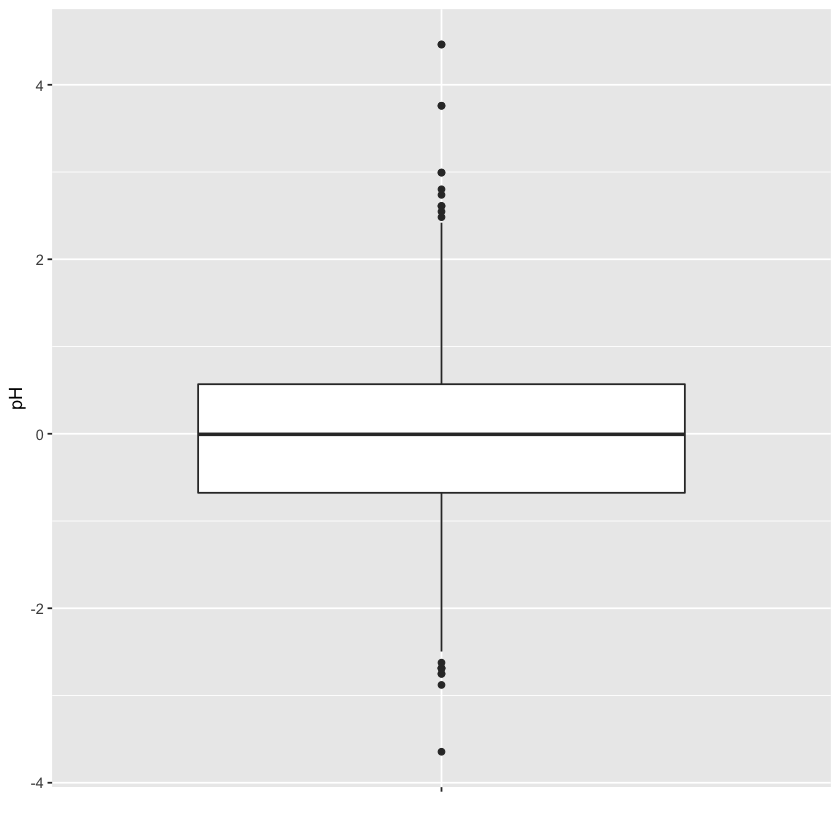

In [50]:
bp.ph <- ggplot(wine_wrangled, aes(x = "", y = pH)) + geom_boxplot() + xlab("")
bp.ph

In [116]:
boxplot.stats(wine_wrangled$pH)

$stats
[1] -2.495881147 -0.676701940 -0.006478021  0.567999623  2.419094254

$n
[1] 1143

$conf
[1] -0.06464804  0.05169200

$out
 [1]  3.759542  2.802079 -3.644836 -2.751205 -2.878866  2.738249  2.610587
 [8] -2.687374 -2.687374  3.759542  2.546756 -2.687374  2.993572  2.482925
[15]  2.993572  4.461681 -2.623543  4.461681 -2.751205  2.610587

#### pH Outliers Count: 20

## Graphing the Relationship of the Variables with Quality

In [59]:
aggregate(x = wine_wrangled$volatile.acidity, by = list(wine_wrangled$quality), FUN = mean) 

Group.1,x
<ord>,<dbl>
0,1.10806933
1,0.08167755
2,-0.75723264


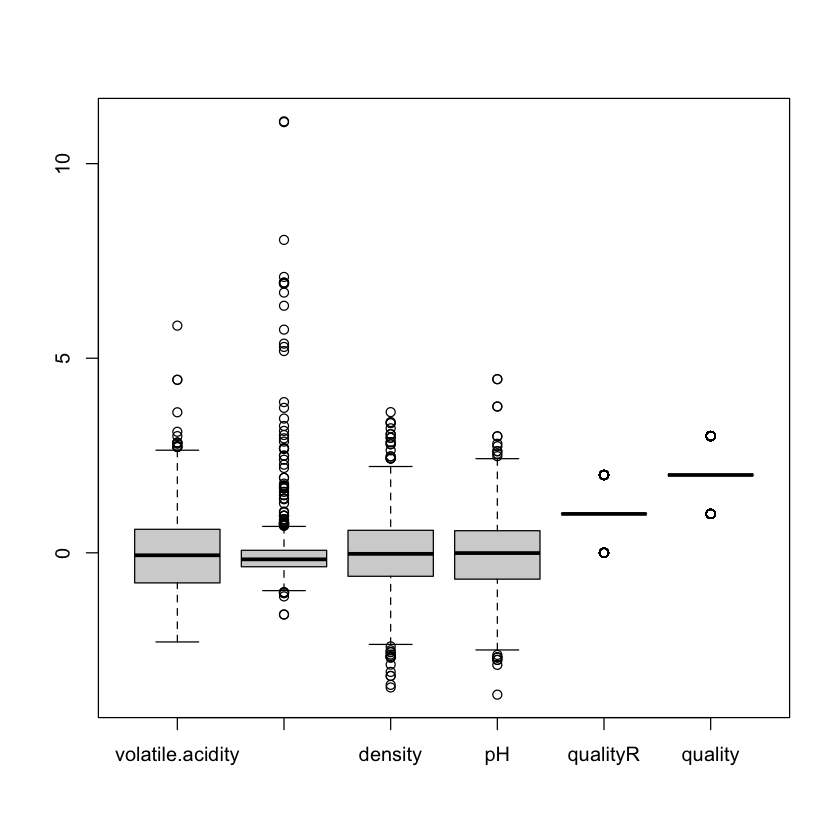

In [60]:
boxplot(wine_wrangled)

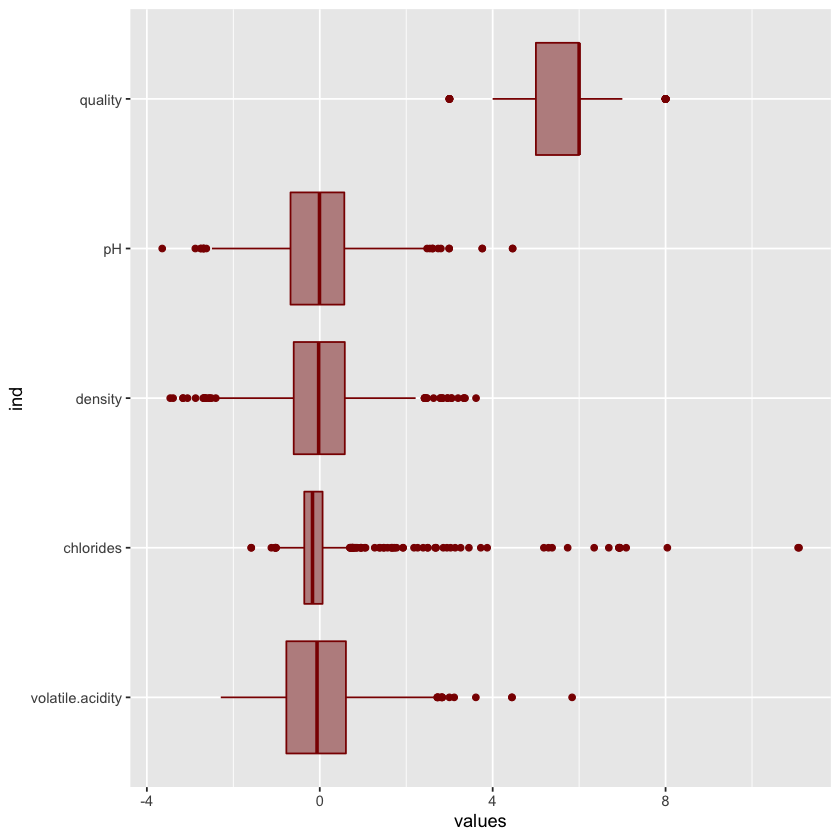

In [167]:
ggplot(stack(wine_wrangled), aes(x = ind, y = values))+
  geom_boxplot(fill='rosybrown', color="darkred") +
  coord_flip()

## Remove Outliers

### Chlorides

In [61]:
chloride.Q1 <- quantile(wine_wrangled$chlorides, .25)
chloride.Q3 <- quantile(wine_wrangled$chlorides, .75)
chloride.IQR <- IQR(wine_wrangled$chlorides)

In [62]:
no.chlorides.outliers <- subset(wine_wrangled, wine_wrangled$chlorides > (chloride.Q1 - 1.5*chloride.IQR) 
                                & wine_wrangled$chlorides < (chloride.Q3 + 1.5*chloride.IQR))

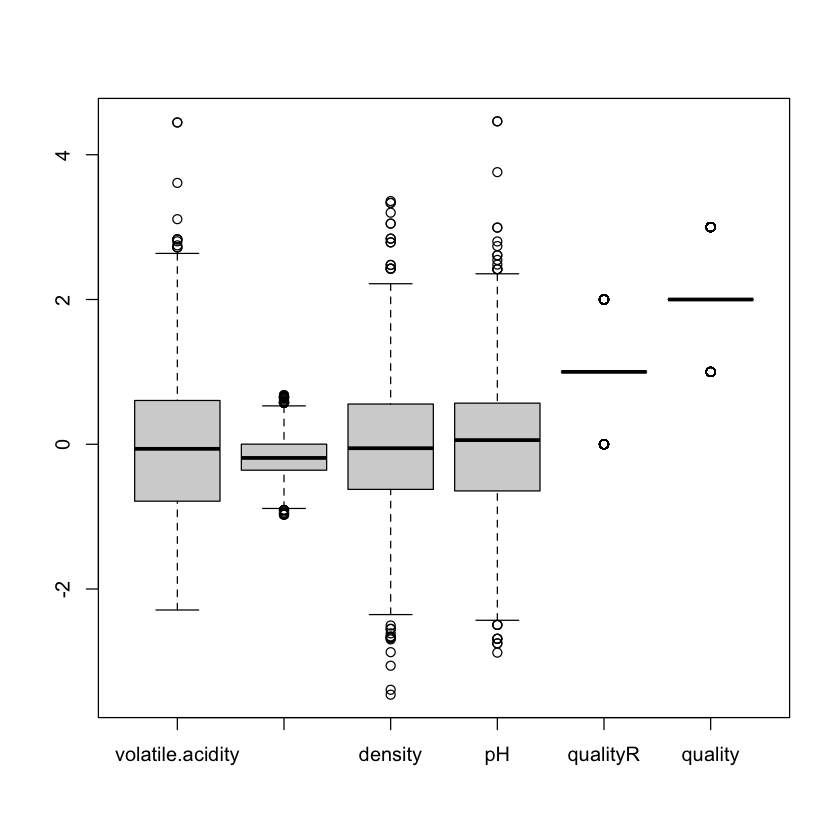

In [63]:
boxplot(no.chlorides.outliers)

### Recheck Outlier Count

#### pH

In [64]:
boxplot.stats(no.chlorides.outliers$pH)

$stats
[1] -2.43205030 -0.64478652  0.05735283  0.56799962  2.35526340

$n
[1] 1066

$conf
[1] -0.001336983  0.116042639

$out
 [1]  3.759542  2.802079  2.419094  2.419094 -2.751205 -2.878866  2.738249
 [8] -2.495881 -2.495881  2.610587 -2.687374 -2.687374 -2.495881  2.546756
[15]  2.419094 -2.687374  2.993572  2.482925  2.993572  4.461681  4.461681
[22] -2.751205  2.610587

#### Volatile Acidity

In [65]:
boxplot.stats(no.chlorides.outliers$volatile.acidity)

$stats
[1] -2.28988070 -0.78681774 -0.06312075  0.60490723  2.63682569

$n
[1] 1066

$conf
[1] -0.130469871  0.004228362

$out
 [1] 2.720329 4.446068 4.446068 2.831667 3.110012 2.831667 2.720329 2.803833
 [9] 2.748164 2.720329 3.611033 2.831667

#### Density

In [66]:
density_Q1 <- quantile(no.chlorides.outliers$density, .25)
density_Q3 <- quantile(no.chlorides.outliers$density, .75)
density_IQR <- IQR(no.chlorides.outliers$density)

In [68]:
no_outliers_cd <- subset(no.chlorides.outliers, no.chlorides.outliers$density > (density_Q1 - 1.5*density_IQR) & 
                         no.chlorides.outliers$density < (density_Q3 + 1.5*density_IQR))

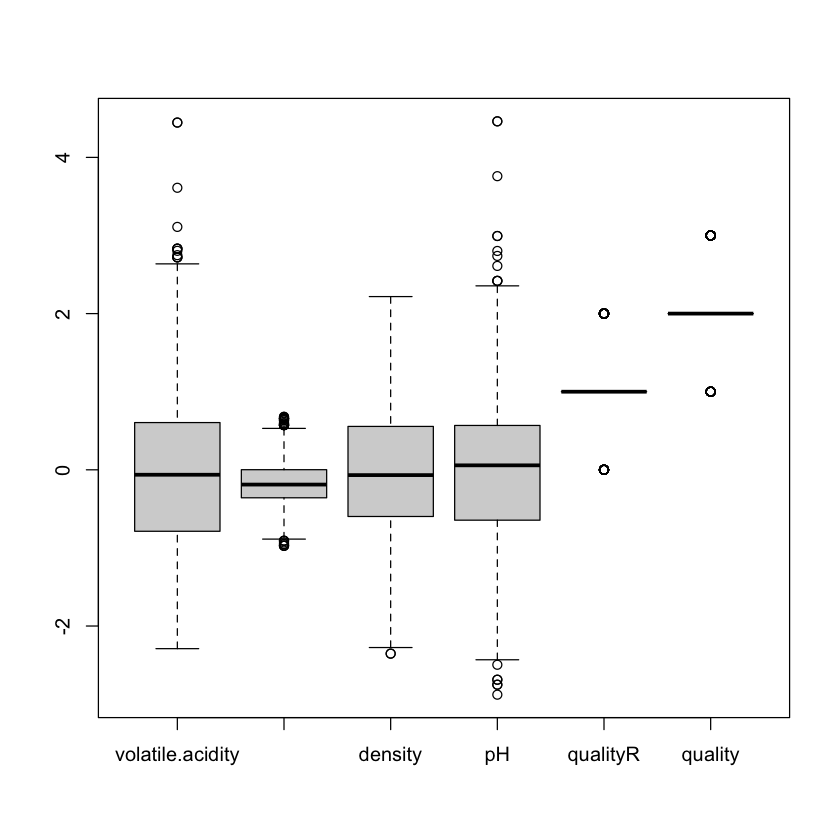

In [69]:
boxplot(no_outliers_cd)

### Recount Outliers

In [70]:
boxplot.stats(no_outliers_cd$volatile.acidity)

$stats
[1] -2.28988070 -0.78681774 -0.06312075  0.60490723  2.63682569

$n
[1] 1037

$conf
[1] -0.131405096  0.005163587

$out
 [1] 2.720329 4.446068 4.446068 2.831667 3.110012 2.831667 2.720329 2.803833
 [9] 2.748164 2.720329 3.611033 2.831667

In [71]:
boxplot.stats(no_outliers_cd$pH)

$stats
[1] -2.43205030 -0.64478652  0.05735283  0.56799962  2.35526340

$n
[1] 1037

$conf
[1] -0.002151963  0.116857619

$out
 [1]  3.759542  2.802079  2.419094  2.419094 -2.751205 -2.878866  2.738249
 [8] -2.687374 -2.687374 -2.495881  2.419094  2.993572  2.993572  4.461681
[15]  4.461681 -2.751205  2.610587